<a href="https://colab.research.google.com/github/sharabhshukla/bayesian-load-forecasting/blob/master/Prophet_modelling_energy_demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Install pwl fit for generating on linear fetaures for temeprature
!pip install git+https://github.com/google/pwlfit.git

  Cloning https://github.com/google/pwlfit.git to /tmp/pip-req-build-d9im4c_y
  Running command git clone -q https://github.com/google/pwlfit.git /tmp/pip-req-build-d9im4c_y
  Created wheel for pwlfit: filename=pwlfit-0.1.0-cp37-none-any.whl size=26438 sha256=8519582b32dea04cdc20980ce8b4a9261cdbf145dbe1121870e279407cecfb49
  Stored in directory: /tmp/pip-ephem-wheel-cache-lpz9xfk_/wheels/8e/8d/af/271f7ad7320ba2df0b7fc036b4649095edc9bfffda9d590cdf
Successfully built pwlfit


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [3]:
import plotly.io as pio
pio.renderers.default = 'colab'

In [4]:
#read the dataset
custome_datetime = lambda x : datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
raw_df = pd.read_csv('https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/nyc_energy_consumption.csv', parse_dates=['timeStamp'], index_col=['timeStamp'])

In [5]:
raw_df.head()

demand  precip   temp
timeStamp                                 
2012-01-01 00:00:00  4937.5     0.0  46.13
2012-01-01 01:00:00  4752.1     0.0  45.89
2012-01-01 02:00:00  4542.6     0.0  45.04
2012-01-01 03:00:00  4357.7     0.0  45.03
2012-01-01 04:00:00  4275.5     0.0  42.61

In [6]:
px.line(raw_df, x= raw_df.index, y='demand' )

In [7]:
px.scatter(raw_df, x=raw_df.index, y='temp')
#raw_df['temp'].plot()

In [8]:
px.line(raw_df, x=raw_df.index, y='precip')

In [9]:
ny_daily_df = raw_df.resample('D').mean()

In [10]:
def is_missing_steps(df):
  start = df.index[0]
  end = df.index[-1]
  df_index = pd.date_range(start,end, freq='D')
  return not df_index.equals(df.index)


def find_missing_steps(df):
  start = df.index[0]
  end = df.index[-1]
  df_index = pd.date_range(start,end, freq='D')
  return df_index.differece(df.index)

In [11]:
is_missing_steps(ny_daily_df)

False

In [12]:
ny_daily_df.isnull().mean()

demand    0.000975
precip    0.000488
temp      0.000488
dtype: float64

In [13]:
#Adding missing indicator
for columns in ny_daily_df.columns:
  ny_daily_df[columns].interpolate(method='time', inplace=True)

In [14]:
ny_daily_df

demand    precip       temp
timeStamp                                   
2012-01-01  4954.833333  0.002487  46.510000
2012-01-02  5302.954167  0.000000  40.496667
2012-01-03  6095.512500  0.000000  26.672500
2012-01-04  6336.266667  0.000000  20.585000
2012-01-05  6130.245833  0.000000  33.577500
...                 ...       ...        ...
2017-08-08  6471.626042  0.000000  71.039167
2017-08-09  6811.112167  0.047529  73.852500
2017-08-10  5582.297000  0.002033  75.217500
2017-08-11  5582.297000  0.000000  72.767917
2017-08-12  5582.297000  0.000443  69.771429

[2051 rows x 3 columns]

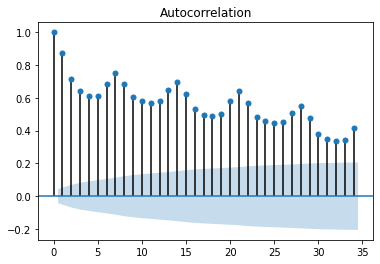

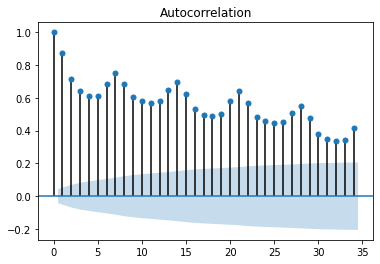

In [15]:
plot_acf(ny_daily_df['demand'])

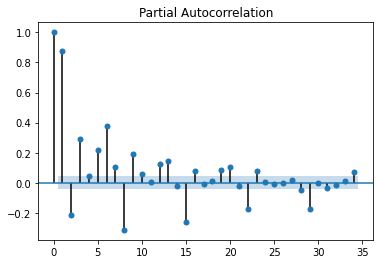

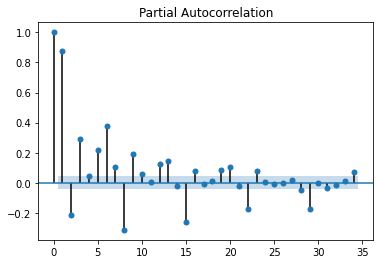

In [16]:
plot_pacf(ny_daily_df['demand'])

In [17]:
from pwlfit import fitter
curve_fit = fitter.fit_pwl(ny_daily_df.iloc[:-7*3, ny_daily_df.columns.get_loc('temp')], ny_daily_df.iloc[:-7*3, ny_daily_df.columns.get_loc('demand')] , num_segments=2, mono=False)

In [18]:
px.scatter(x=ny_daily_df['precip'], y=ny_daily_df['demand'])

In [19]:
px.scatter(x=ny_daily_df['precip'], y=ny_daily_df['demand'], color=ny_daily_df['temp'])

In [20]:
px.scatter(x=ny_daily_df['temp'], y=curve_fit.eval(ny_daily_df['temp']))

In [21]:
px.scatter(ny_daily_df, x=ny_daily_df['temp'], y=ny_daily_df['demand'])

In [22]:
ny_daily_df['tempFeat_1'] = curve_fit.eval(ny_daily_df['temp'])

In [23]:
#Introducing AR order 5 terms
AR_ORDER = np.arange(1,4)
for order in AR_ORDER:
  ny_daily_df['AR_ORDER_' + str(order)] = ny_daily_df['demand'].shift(-order)

In [24]:
ny_daily_df.dropna(inplace=True)

In [25]:
ny_daily_df.head()

demand    precip  ...   AR_ORDER_2   AR_ORDER_3
timeStamp                          ...                          
2012-01-01  4954.833333  0.002487  ...  6095.512500  6336.266667
2012-01-02  5302.954167  0.000000  ...  6336.266667  6130.245833
2012-01-03  6095.512500  0.000000  ...  6130.245833  5867.537500
2012-01-04  6336.266667  0.000000  ...  5867.537500  5177.441667
2012-01-05  6130.245833  0.000000  ...  5177.441667  5120.541667

[5 rows x 7 columns]

In [26]:
prophet_df = ny_daily_df.reset_index()

In [27]:
prophet_df.head()

timeStamp       demand    precip  ...   AR_ORDER_1   AR_ORDER_2   AR_ORDER_3
0 2012-01-01  4954.833333  0.002487  ...  5302.954167  6095.512500  6336.266667
1 2012-01-02  5302.954167  0.000000  ...  6095.512500  6336.266667  6130.245833
2 2012-01-03  6095.512500  0.000000  ...  6336.266667  6130.245833  5867.537500
3 2012-01-04  6336.266667  0.000000  ...  6130.245833  5867.537500  5177.441667
4 2012-01-05  6130.245833  0.000000  ...  5867.537500  5177.441667  5120.541667

[5 rows x 8 columns]

In [28]:
#Feature engineering
#Day of the week, day of the month, hour of the day
#prophet_df['day_week'] = prophet_df['timeStamp'].dt.dayofweek
#prophet_df['month'] = prophet_df['timeStamp'].dt.month
prophet_df['quarter'] = prophet_df['timeStamp'].dt.quarter

In [29]:
prophet_df.rename({'timeStamp': 'ds', 'demand': 'y', 'precip': 'precip', 'temp': 'temp'}, axis=1, inplace=True)

In [30]:
prophet_df.head()

ds            y    precip  ...   AR_ORDER_2   AR_ORDER_3  quarter
0 2012-01-01  4954.833333  0.002487  ...  6095.512500  6336.266667        1
1 2012-01-02  5302.954167  0.000000  ...  6336.266667  6130.245833        1
2 2012-01-03  6095.512500  0.000000  ...  6130.245833  5867.537500        1
3 2012-01-04  6336.266667  0.000000  ...  5867.537500  5177.441667        1
4 2012-01-05  6130.245833  0.000000  ...  5177.441667  5120.541667        1

[5 rows x 9 columns]

In [31]:
training_df = prophet_df[:-7*3]
test_df = prophet_df[-7*3:]

In [32]:
from fbprophet import Prophet

model = Prophet(mcmc_samples=100, interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True)
model.add_country_holidays('US')

In [33]:
regressor_columns = ['temp', 'quarter', 'tempFeat_1', 'precip', 'AR_ORDER_1', 'AR_ORDER_2', 'AR_ORDER_3']
for cols in regressor_columns:
    if cols in ['temp', 'tempFeat_1', 'precip', 'AR_ORDER_1', 'AR_ORDER_2', 'AR_ORDER_3']:
      model.add_regressor(cols, standardize=True, mode='additive')
    else:
      model.add_regressor(cols, standardize=False, mode='additive')

In [34]:
model.fit(training_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [35]:
future = model.make_future_dataframe(7*3)

In [36]:
for cols in regressor_columns:
  future[cols] = prophet_df[cols]

In [37]:
forecast = model.predict(future)

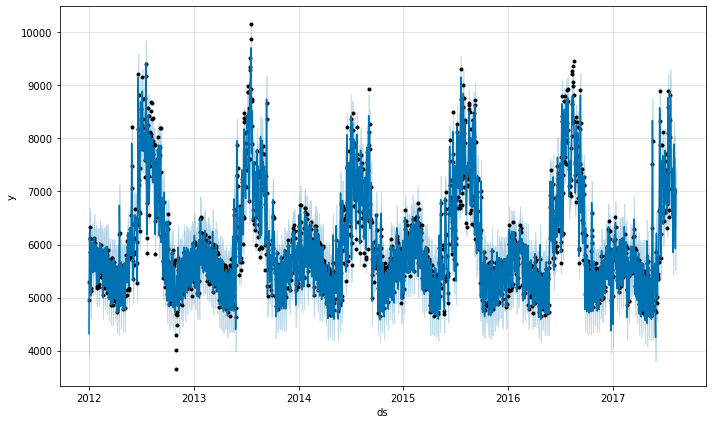

In [38]:
model.plot(forecast);

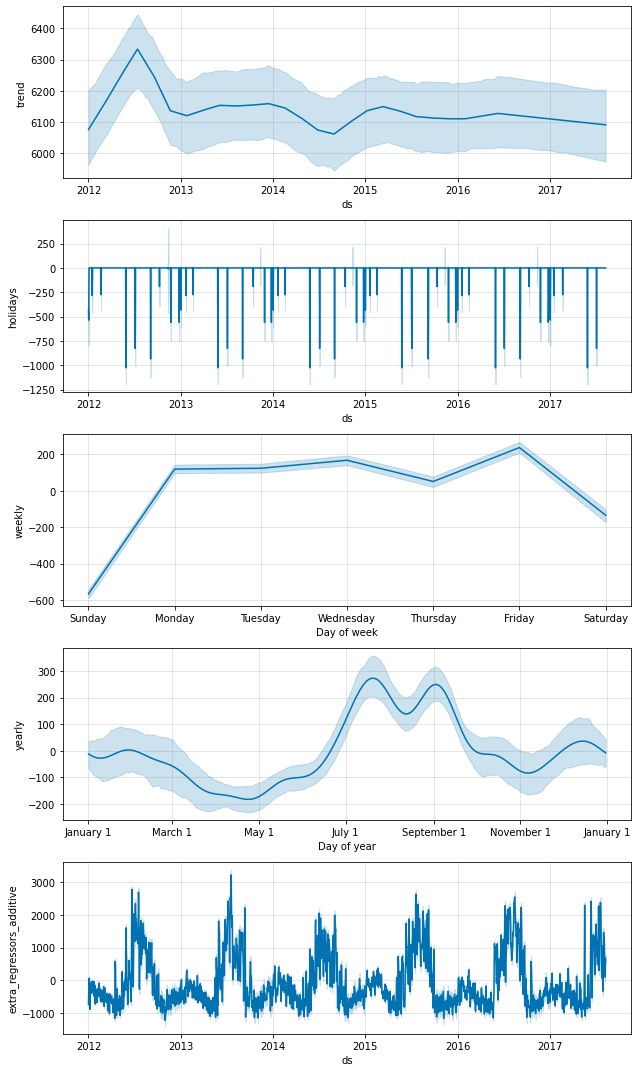

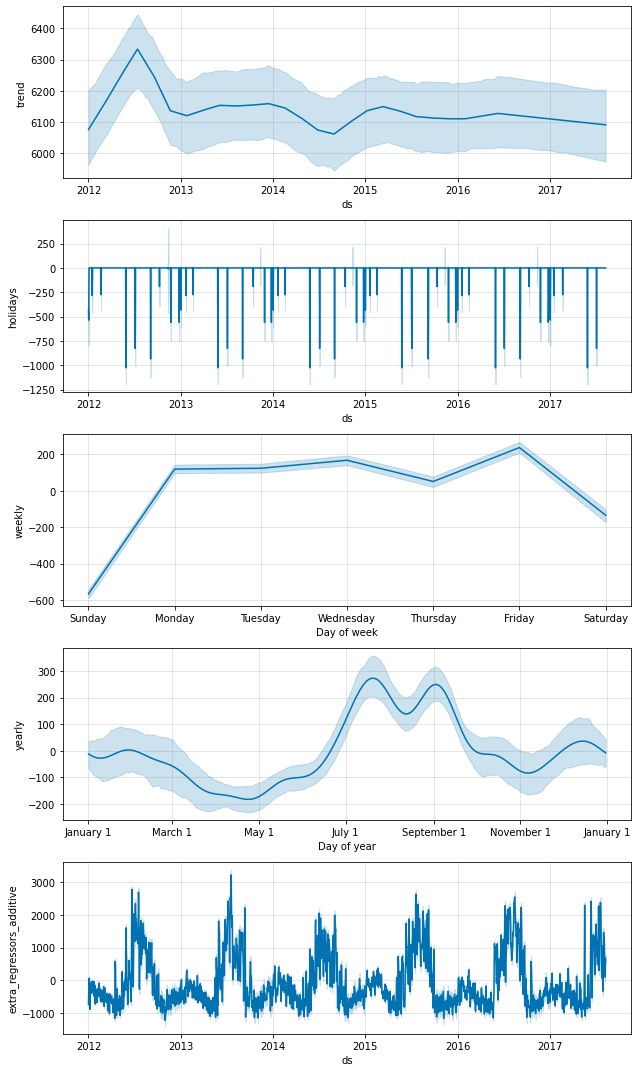

In [39]:
model.plot_components(forecast)

In [40]:
sample_predictions = model.predictive_samples(future)

In [41]:
sample_predictions_df = pd.DataFrame(sample_predictions['yhat'])

In [42]:
fcst_melt = pd.melt(sample_predictions_df.iloc[-100:,0:5])

In [43]:
fig_1 = px.line(fcst_melt, y='value', color='variable')

In [44]:
fig_2 = px.line(y=ny_daily_df.iloc[-100:, ny_daily_df.columns.get_loc('demand')])

In [45]:
fig_1

In [46]:
fig_2


In [47]:
from fbprophet.diagnostics import cross_validation, performance_metrics

In [ ]:
df_cv = cross_validation(model, initial= '1500 days', horizon='30 days')
df_p = performance_metrics(df_cv)
df_p.head(5)

INFO:fbprophet:Making 34 forecasts with cutoffs between 2016-02-10 00:00:00 and 2017-06-19 00:00:00


To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
